# Variational Latent Gaussian Process
#### A tutorial

In [1]:
%load_ext autoreload
%autoreload 2
%aimport vlgp

Firstly import modules.

In [38]:
import os
from os import path

import numpy as np
from scipy import stats
from scipy import linalg
from scipy.io import loadmat, savemat

import vlgp
from vlgp import util, simulation, math, plot

Then import and set up graphics. We borrow the palette from seaborn. 

In [96]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set(context='notebook', style='white', palette='deep', font_scale=1.5, color_codes=True)

Set up the paths to the data and ouput directories or create them in current directory if they do not exist.

In [7]:
datapath = path.abspath('data')
outputpath = path.abspath('output')

## Lorenz Dynamics

We simulate a dataset driven by 3-dimensional Lorenz dynamics defined by the following differential equations,
\begin{align} 
    x_1' &= \sigma(x_2 - x_1)     \\
    x_2' &= x_1(\rho - x_3) - x_2 \\
    x_3' &= x_1 x_2 - \beta x_3.
\end{align}

This dataset consists of 10 trials of 50 spike trains. Each trial contains 1000 time bins. The discrete latent dynamics are sampled with the time step of 0.0015. The parameters are set to $\sigma=10$, $\rho=28$ and $\beta=2.667$. We normalize the dynamics and discard the first 2000 points to get stable result.

In [16]:
ntrial = 10  # number of trials
nbin = 1000  # number of time bins of each trial
nneuron = 50 # number of neurons (spike trains)
dim = 3      # latent dimension

In [21]:
np.random.seed(0)
skip = 2000
lorenz = simulation.lorenz(skip + ntrial * nbin, dt=1.5e-3, s=10, r=28, b=2.667, x0=np.random.random(3) * 2)
lorenz = (lorenz - lorenz.mean(axis=0)) / linalg.norm(lorenz, axis=0, ord=np.inf)
x = lorenz[skip:, :].reshape((ntrial, nbin, dim))  # latent dynamics in proper shape

Simulate spike trains with 10-step history filter given the simulated latent dynamics. The elements of loading matrix is randomly generated from $(1, 2)$ with random signs. The history filter decays in time $(-10, -10, -3, -3, -3, -3, -2, -2, -1, -1)$. The base firing rate is 15Hz. 

The simulation function `simulation.spike` gives spike trains, design matrix of regression part and the true firing rates. We save the simulation in HDF5 format.

In [24]:
np.random.seed(0)
bias = np.log(15 / nbin)  # log base firing rate
a = (np.random.rand(dim, nneuron) + 1) * np.sign(np.random.randn(dim, nneuron))  # loading matrix
b = np.vstack((bias * np.ones(nneuron), -10 * np.ones(nneuron), -10 * np.ones(nneuron), -3 * np.ones(nneuron), 
                  -3 * np.ones(nneuron), -3 * np.ones(nneuron), -3 * np.ones(nneuron), -2 * np.ones(nneuron),
                  -2 * np.ones(nneuron), -1 * np.ones(nneuron), -1 * np.ones(nneuron)))  # regression weights

y, _, rate = simulation.spike(x, a, b)

sample = dict(y=y, rate=rate, x=x, alpha=a, beta=b)

util.save(sample, op.join(datapath, 'lorenz.h5'))  # store the simulation

Load the simulation.

In [101]:
sample = util.load(op.join(datapath, 'lorenz.h5'))

Plot the latent dynamics.

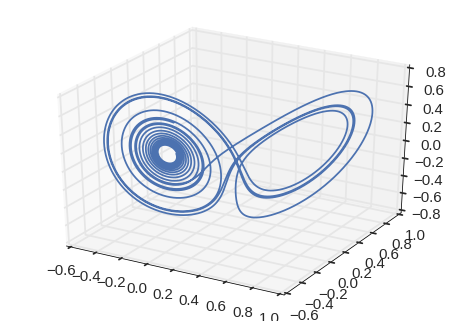

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(sample['x'][:, :, 0].ravel(), sample['x'][:, :, 1].ravel(), zs=sample['x'][:, :, 2].ravel());

Plot the spike trains.

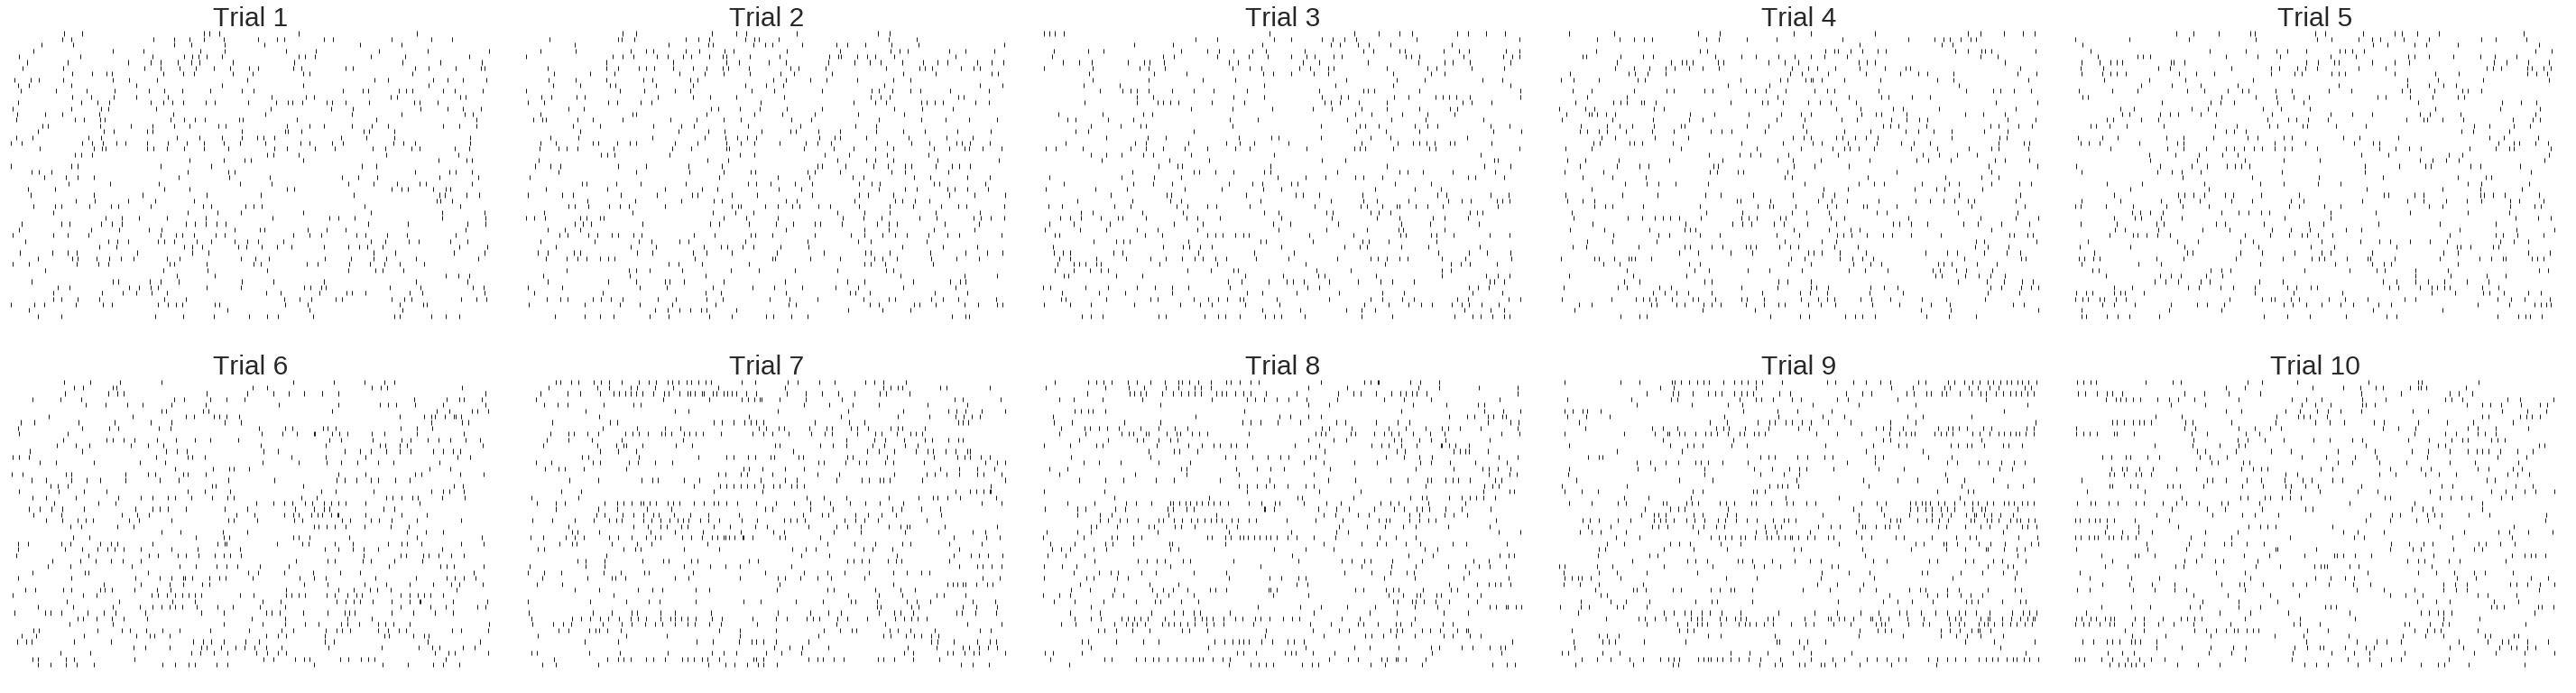

In [103]:
plot.spike(sample['y'], ncol=5, fontsize=30)

### Model Fitting

In [68]:
np.random.seed(0)
fitted, _ = vlgp.fit(sample['y'], ['spike']*sample['y'].shape[-1], 
                     sigma=np.full(nlatent, fill_value=1.0), omega=np.full(nlatent, fill_value=1e-5), 
                     lag=10, rank=100, 
                     x=sample['x'], alpha=sample['alpha'], beta=sample['beta'],  
                     niter=100, tol=1e-5, adjhess=True, decay=0, verbose=False, learn_post=True, learn_param=True,
                     learn_sigma=True, learn_omega=True, nhyper=5)

util.save(fitted, op.join(outputpath, 'lorenz.h5'))

/home/yuan/variational/vlgp/util.py:203: UserWarning: Discard unsupported type (channel)
  


Load results. The fits of PLDS and GPFA should be put in the output path before loading.

In [99]:
fit = util.load(op.join(outputpath, 'lorenz.h5'))

Angle between subspaces of latent vs time

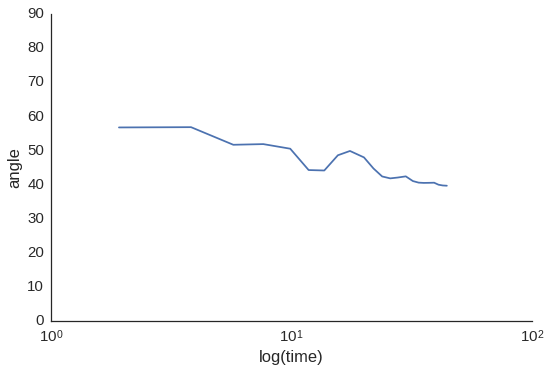

In [100]:
plt.figure()
plt.semilogx(np.cumsum(fit['Elapsed'][:, 2]), fit['LatentAngle'])
plt.xlabel('log(time)')
plt.ylabel('angle')
plt.ylim(0, 90)
sns.despine(top=True, right=True)
plt.tight_layout()

### Leave-one-out

We use a leave-one-neuron-out prediction likelihood to compare models.
We choose one of the trials as test trial and the others as training trials.
First, the weights and posterior are inferred from the training trials.
Next, we leave one neuron out of the test trial and make inference on the posterior of the test trial given the rest neurons and the weights estimated from the training trials.
Then the firing rates of the very neuron are predicted by the model given the weights from the training trials and the posterior inferred from the rest of neurons in the test trial.
We do this procedure on each neuron of one trial and each trial of the sample.
Finally we obtain the prediction of all neurons at all time bins of the sample.

Here we fixed the hyperparameters to the values inferred early.

In [73]:
sigma = fit['sigma']
omega = fit['omega']
np.random.seed(0)
result = vlgp.cv(sample['y'], ['spike']*sample['y'].shape[-1], 
                     sigma, omega, lag=10, rank=100,  
                     niter=100, tol=1e-5, adjhess=True, decay=0, verbose=False, learn_post=True, learn_param=True,
                     learn_sigma=False, learn_omega=False, nhyper=5)

util.save(result, op.join(outputpath, 'lorenz_cv.h5'))

## Linear Dynamical System

Now we simulate another dataset of which the latent dynamics is defined by the following linear dynamical system (LDS) (Buesing 2012).
\begin{align}
    y_{t,n} \mid \mathbf{x}_t &\sim Poisson(\ln(1 + \exp(\mathbf{c}_n^\top \mathbf{x}_t + \mathbf{d}_n)) \\
    \mathbf{x}_0 &\sim \mathcal{N}(\boldsymbol{\mu}_0, Q_0) \\
    \mathbf{x}_{t+1} \mid \mathbf{x}_t &\sim \mathcal{N}(A \mathbf{x}_t + \mathbf{b}_t, Q)
\end{align}

The dataset has the same shape as the Lorenz data and was simulated by the [code](https://bitbucket.org/mackelab/pop_spike_dyn). Note that we changed the canonical link function. We totally simulated 5 samples.

In [83]:
nsample = 5
ntrial = 10
nbin = 1000
nneuron = 50
dim = 3

Load the data. *The data files should be in the data directory before running the following code.*

In [85]:
samples = [util.load(op.join(datapath, 'lds{}.h5'.format(i + 1))) for i in range(nsample)]

Plot the dynamics of one sample.

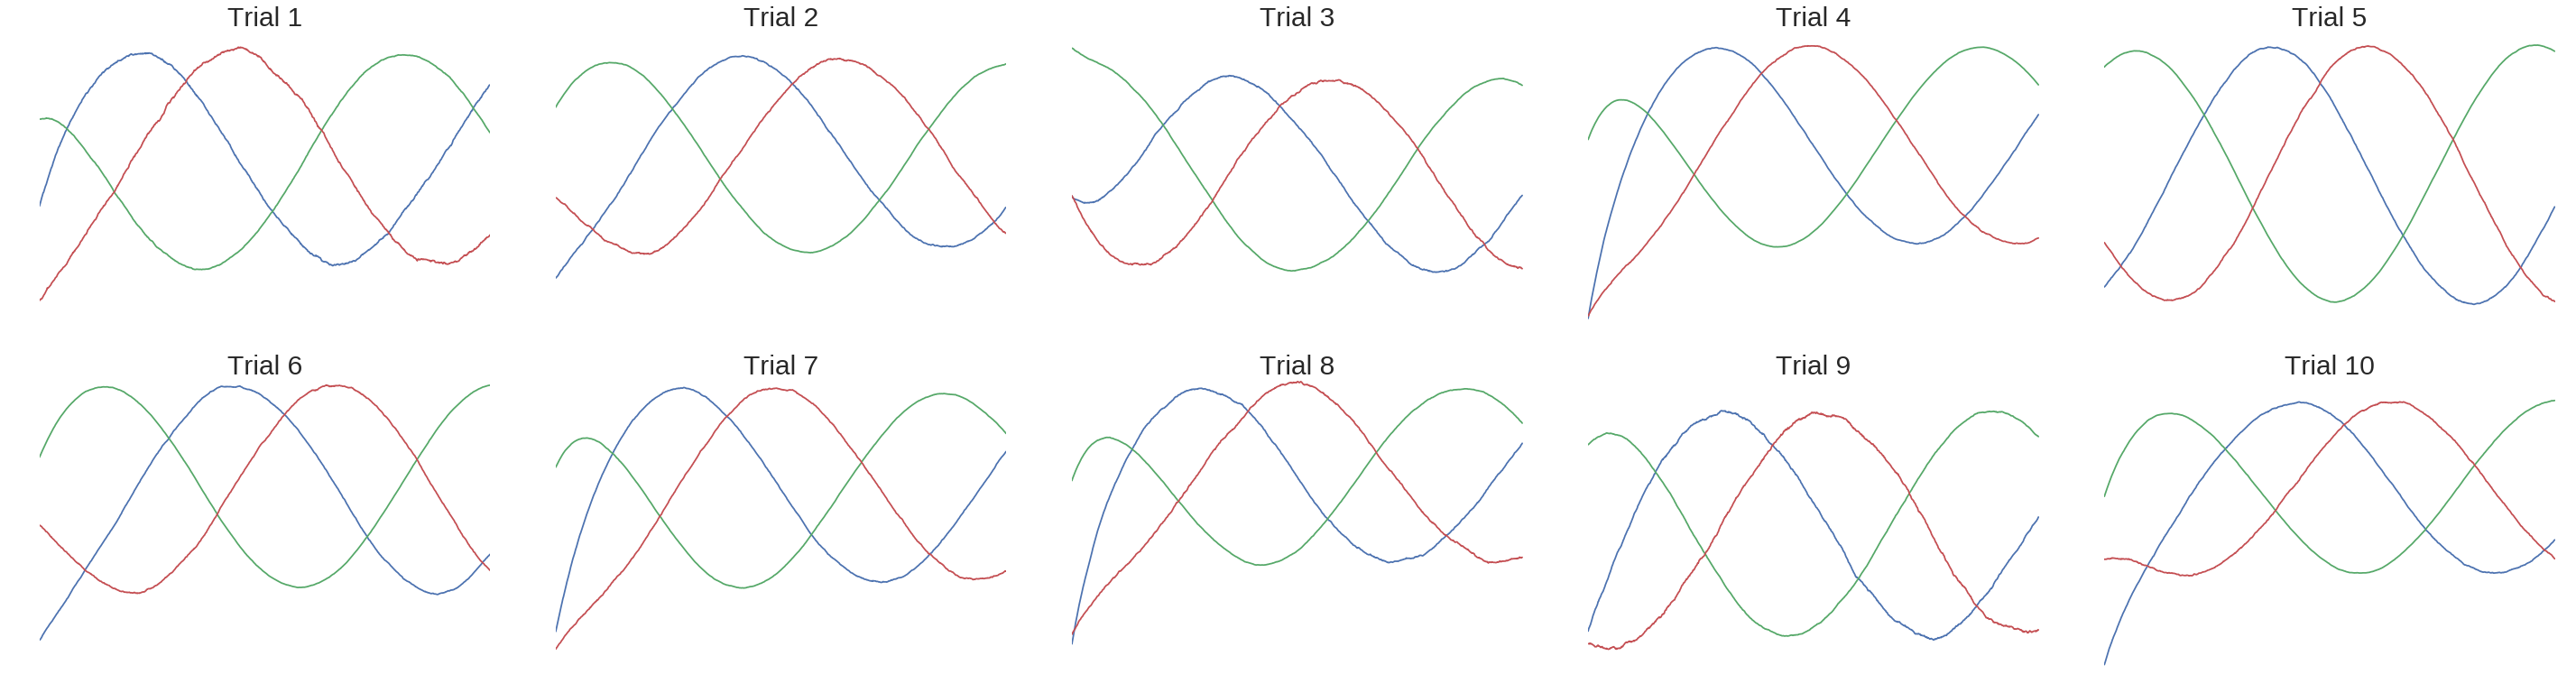

In [98]:
plot.dynamics(samples[0]['x'], ncol=5, fontsize=30)

### Model Fitting

In [84]:
for i, sample in enumerate(samples, start=1):
    fitted, _ = vlgp.fit(sample['y'], ['spike'] * sample['y'].shape[-1], 
                         sigma=np.full(nlatent, fill_value=1.0), omega=np.full(nlatent, fill_value=1e-5),
                         lag=0, rank=100,
                         x=sample['x'], alpha=sample['alpha'], beta=sample['beta'],  
                         niter=100, tol=1e-5, adjhess=True, decay=0, verbose=False, learn_post=True, learn_param=True,
                         learn_sigma=True, learn_omega=True, nhyper=5)
    util.save(fitted, op.join(outputpath, 'lds{}.h5'.format(i + 1)))

/home/yuan/variational/vlgp/util.py:203: UserWarning: Discard unsupported type (channel)
  


In [86]:
fitteds = [util.load(op.join(outputpath, 'lds{}.h5'.format(i + 1))) for i in range(nsample)]

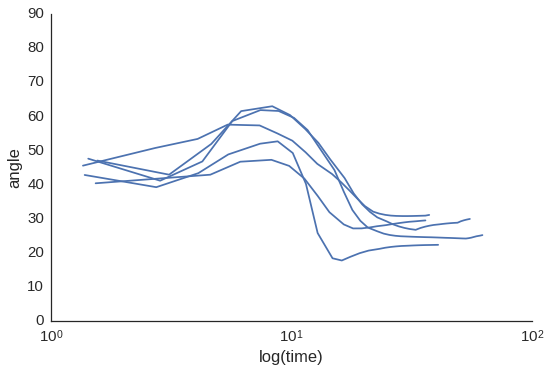

In [97]:
plt.figure()
for fitted in fitteds:
    plt.semilogx(np.cumsum(fitted['Elapsed'][:, 2]), fitted['LatentAngle'], color='b')
plt.xlabel('log(time)')
plt.ylabel('angle')
plt.ylim(0, 90)
sns.despine(top=True, right=True)
plt.tight_layout()